# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from time import time

torch.manual_seed(0)

## 1. Data exploration

In [2]:
BATCH_SIZE = 64

data_transforms = transforms.ToTensor()

## TRAIN set
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
#print(len(trainset))

## TEST set
testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=data_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
#print(len(testset))

60000


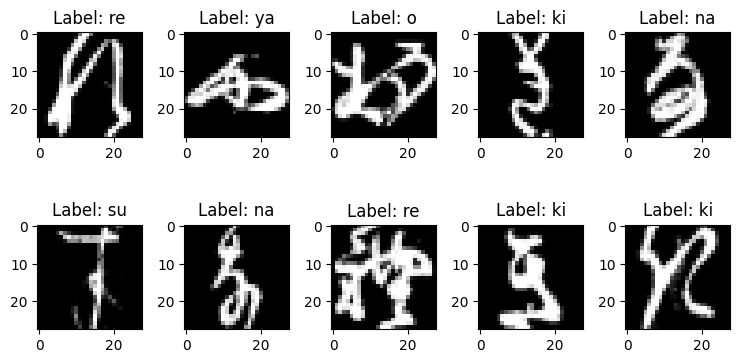

Classes: ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']


In [4]:
num_row = 2
num_col = 5

classes = trainset.classes

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(classes[trainset.targets[i]]))
plt.tight_layout()
plt.show()

print(f'Classes: {classes}')

In [5]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


## Model building

#### CONVOLUTIONAL

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)   
            # Conv2D --> 2D images
            # in_channels --> colori: in questo caso 1 (bianco e nero)

        # layer lineari
        self.l1 = nn.Linear(32 * 26 * 26, 128)
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)

        # Activation function
        x = F.relu(x)

        # flatten => BS x (32*26*26) = BS x 21632
        x = x.flatten(start_dim = 1)

        # BSx(32*26*26) => BSx128
        x = self.l1(x)

        x = F.relu(x)

        # BSx128 => BSx10
        logits = self.l2(x)

        # Softmax computation: ogni neurone in uscita avra un label assegnato; softmax indica la probabilita che appartenga effettivamente a quella classe
        out = F.softmax(logits, dim=1)

        return out

#### FULLY CONNECTED (FACCO)

In [6]:
class MyFullyConnectedModel(nn.Module):
    def __init__(self):
        super(MyFullyConnectedModel, self).__init__()

        self.l1 = nn.Linear(28 * 28, 32 * 26 * 26)  # Input size: 28*28 (dimensione immagine KMNIST)
        self.l2 = nn.Linear(32 * 26 * 26, 128)
        self.l3 = nn.Linear(128, 10)
 
    def forward(self, x):
        # Flatten: BSx1x28x28 => BSx(28*28)
        x = x.view(x.size(0), -1)
 
        # BSx(28*28) => BSx128
        x = F.relu(self.l1(x))
 
        # BSx128 => BSx64
        x = F.relu(self.l2(x))
 
        # BSx64 => BSx10
        logits = self.l3(x)
 
        # Softmax computation
        out = F.softmax(logits, dim=1)
       
        return out

In [7]:
model = MyModel()
out = model(images)
print(f"Output shape is: {out.shape}  i.e.: batch_size x num_classes")

Output shape is: torch.Size([64, 10])  i.e.: batch_size x num_classes


In [8]:
def get_batch_accuracy(logit, target):
    """Obtain accuracy for one batch of data"""
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

print(f"Accuracy on the single batch just used: {get_batch_accuracy(out, labels)}%")

Accuracy on the single batch just used: 12.5%


In [9]:
# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If you are a rich Mac user
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Re-instantiate the model to reset the weights/gradients.
# Weights are initialized by default according to Kaiming He et al. (2015) | https://arxiv.org/abs/1502.01852
model = MyModel()
model = model.to(device)  # Move the model to the selected device

print(f"Using device: {device}")

Using device: cuda


In [10]:
# Number of times the whole (training) dataset is used for training
num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    # Set the model to training mode: relevant for dropout, batchnorm, etc.
    model = model.train()
    start = time()
    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)

        # Reset the gradients to zero: otherwise they accumulate!
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.item()
        train_acc += get_batch_accuracy(logits, labels)

    model.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}")

Epoch: 1 | Loss: 1.6855 | Train Accuracy: 77.7131 | Time: 8.40
Epoch: 2 | Loss: 1.5845 | Train Accuracy: 87.8902 | Time: 7.88
Epoch: 3 | Loss: 1.5765 | Train Accuracy: 88.7106 | Time: 7.89
Epoch: 4 | Loss: 1.5686 | Train Accuracy: 89.4911 | Time: 7.82
Epoch: 5 | Loss: 1.5671 | Train Accuracy: 89.6378 | Time: 7.84


In [13]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_batch_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i:.4f}")

Test Accuracy: 77.4940
